Poč. komponent: 14
Počty mincí (klasifikace): {np.str_('10 Kc'): np.int64(1), np.str_('5 Kc'): np.int64(4), np.str_('2 Kc'): np.int64(8), np.str_('1 Kc'): np.int64(1)}


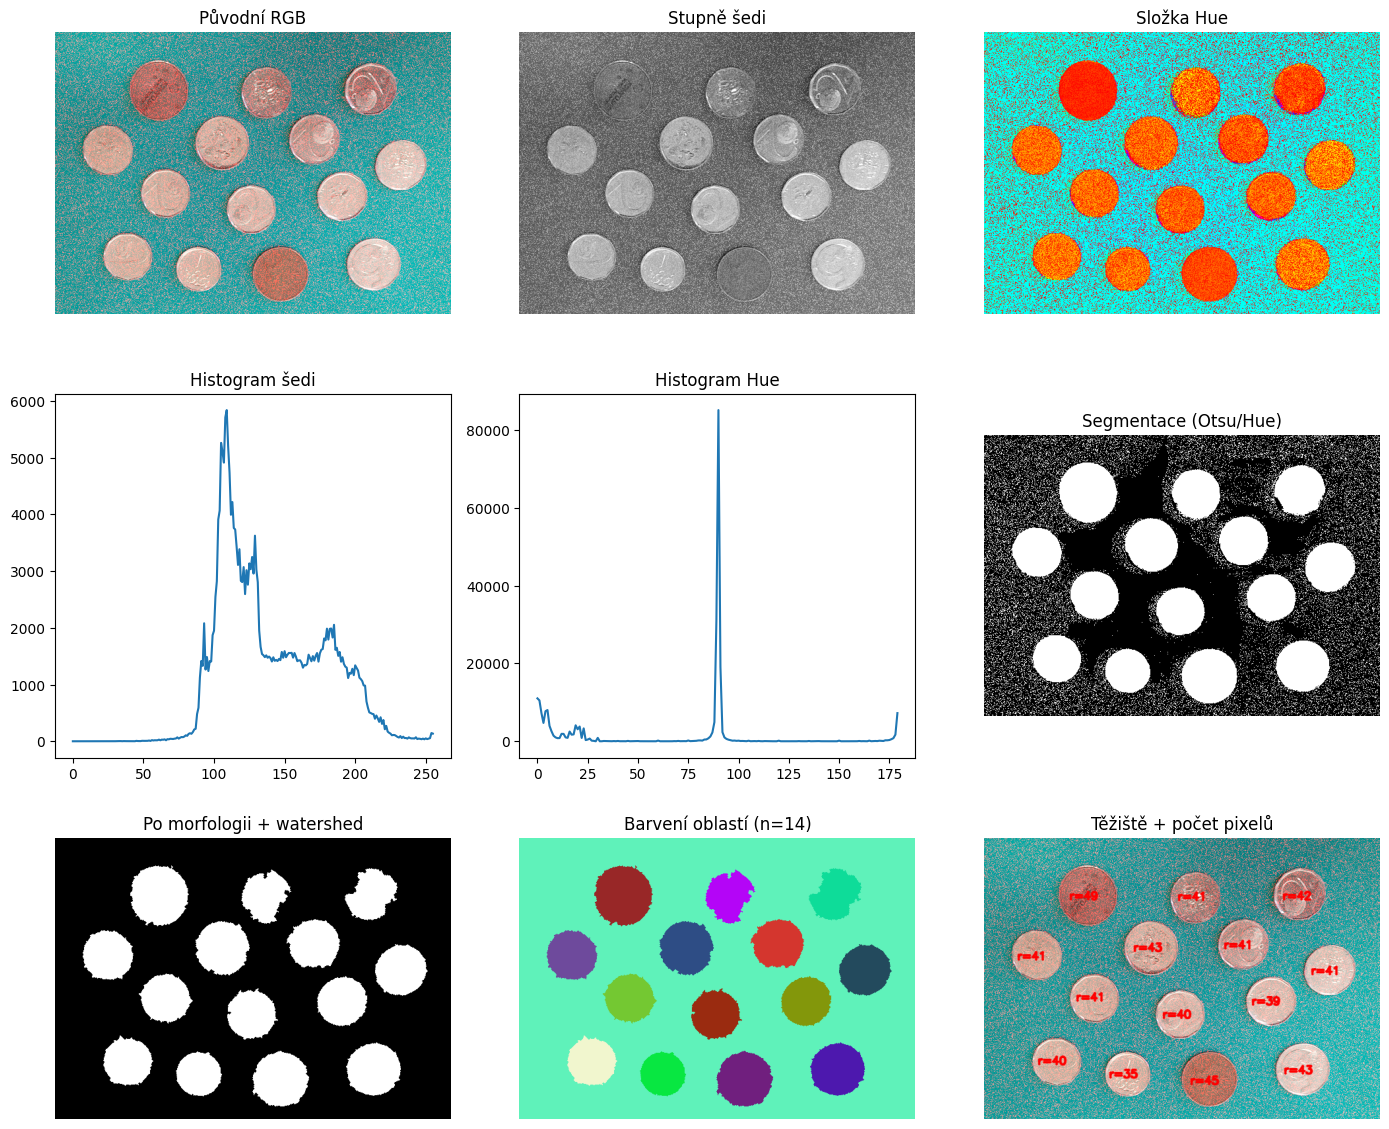

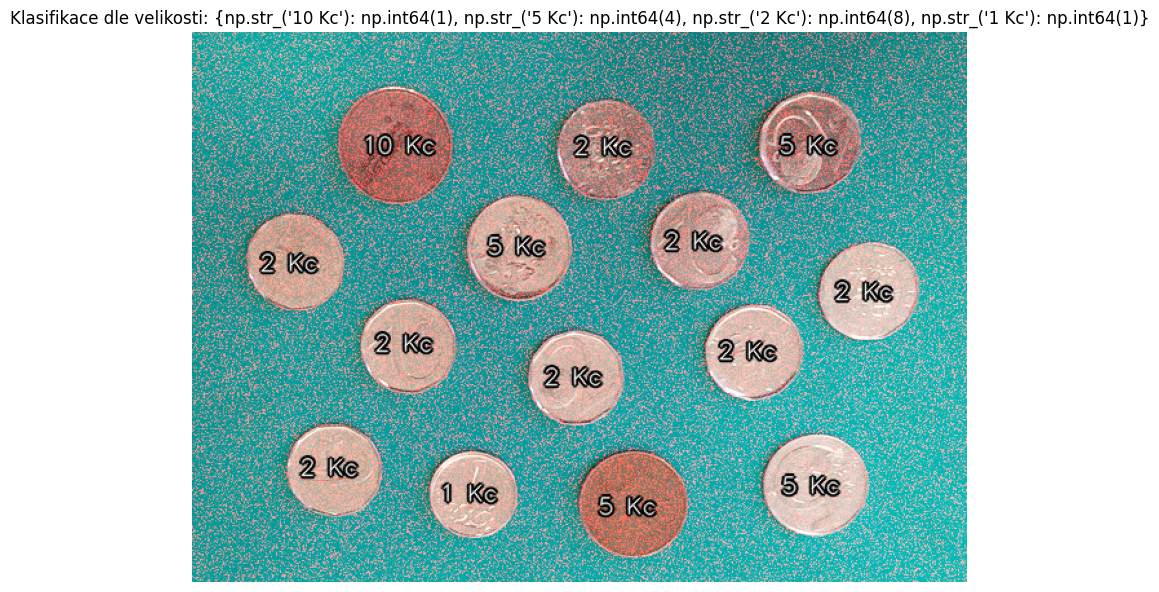

In [7]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from sklearn.cluster import KMeans

IN_PATH = "./pvi_cv05_mince_noise.png"
OUT_DIR = "./out"
os.makedirs(OUT_DIR, exist_ok=True)

img_bgr = cv2.imread(IN_PATH, cv2.IMREAD_COLOR)
if img_bgr is None:
    raise RuntimeError(f"Cannot read {IN_PATH}")
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
hsv  = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
hue  = hsv[:, :, 0]

# histograms
hist_gray = cv2.calcHist([gray], [0], None, [256], [0, 256]).ravel()
hist_hue  = cv2.calcHist([hue],  [0], None, [180], [0, 180]).ravel()

# Otsu thresholds
_, thr_gray = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
_, thr_hue  = cv2.threshold(hue,  0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# choose Hue segmentation (background teal vs coins)
seg = thr_hue
# ensure background is black and coins are white
border = np.hstack([seg[0,:], seg[-1,:], seg[:,0], seg[:,-1]])
if np.mean(border) > 127:
    seg = 255 - seg


# Remove binary noise with morphology (opening + closing)
ker = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
BWop = cv2.morphologyEx(seg, cv2.MORPH_OPEN,  ker, iterations=1)
BWop = cv2.morphologyEx(BWop, cv2.MORPH_CLOSE, ker, iterations=2)

# OPTIONAL: split touching coins using distance-transform + watershed
dist = cv2.distanceTransform(BWop, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist, 0.45 * dist.max(), 255, 0)  # ~0.45 works well here
sure_fg = sure_fg.astype(np.uint8)
sure_bg = cv2.dilate(BWop, ker, iterations=2)
unknown = cv2.subtract(sure_bg, sure_fg)
num_labels, markers = cv2.connectedComponents(sure_fg)  # labels image is 2nd
markers = markers.astype(np.int32) + 1                  # watershed needs int32; shift so bg=1
markers[unknown == 255] = 0                             # 0 marks 'unknown' region

markers = cv2.watershed(img_rgb, markers)               # img_rgb is already 3-channel
BWop = np.uint8(markers > 1) * 255                      # final clean binary mask

# 3) Connected-components labeling (barvení oblastí)
BWlabel, ncc = ndi.label(BWop > 0)   # <-- exactly as you quoted
print("Poč. komponent:", ncc)

# pretty color visualization
rand_colors = np.random.RandomState(42).rand(ncc + 1, 3)
label_vis = (rand_colors[BWlabel] * 255).astype(np.uint8)

# 4) Centroids + pixel counts, annotate counts in original image
#    + size-based classifier (KMeans into 4 size groups)
labels    = np.arange(1, ncc + 1)
areas     = np.array([np.sum(BWlabel == lab) for lab in labels])
centroids = np.array(ndi.center_of_mass(BWop > 0, BWlabel, labels))

overlay_counts = img_rgb.copy()
for (cy, cx), a in zip(centroids, areas):
    cv2.putText(overlay_counts, str(int(a)), (int(cx) - 35, int(cy) + 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.55, (255, 0, 0), 2, cv2.LINE_AA)

# KMeans on area -> 4 clusters; map by mean area to {10,5,2,1}
km = KMeans(n_clusters=4, n_init=20, random_state=0)
clusters = km.fit_predict(areas.reshape(-1, 1))
means = {c: areas[clusters == c].mean() for c in np.unique(clusters)}
ranked = [c for c, _ in sorted(means.items(), key=lambda kv: -kv[1])]
denom_map = {ranked[0]: "10 Kc", ranked[1]: "5 Kc",
             ranked[2]: "2 Kc",  ranked[3]: "1 Kc"}
coin_names = [denom_map[c] for c in clusters]

# counts per class
u, cnt = np.unique(coin_names, return_counts=True)
class_counts = dict(sorted(zip(u, cnt),
                           key=lambda kv: ["10 Kc", "5 Kc", "2 Kc", "1 Kc"].index(kv[0])))
print("Počty mincí (klasifikace):", class_counts)

overlay_cls = img_rgb.copy()
for (cy, cx), name in zip(centroids, coin_names):
    cv2.putText(overlay_cls, name, (int(cx) - 26, int(cy) + 6),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 3, cv2.LINE_AA)
    cv2.putText(overlay_cls, name, (int(cx) - 26, int(cy) + 6),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1, cv2.LINE_AA)

# -------------------------------------------------------------
# 1) One window with converted images, histograms & segmentation
# 2) Result after morphology, 3) labeled, 4) centroids + pixel counts
# -------------------------------------------------------------
plt.figure(figsize=(14, 12))
plt.subplot(3, 3, 1); plt.imshow(img_rgb); plt.title("Původní RGB"); plt.axis("off")
plt.subplot(3, 3, 2); plt.imshow(gray, cmap="gray"); plt.title("Stupně šedi"); plt.axis("off")
plt.subplot(3, 3, 3); plt.imshow(hue, cmap="hsv"); plt.title("Složka Hue"); plt.axis("off")
plt.subplot(3, 3, 4); plt.plot(hist_gray); plt.title("Histogram šedi")
plt.subplot(3, 3, 5); plt.plot(hist_hue); plt.title("Histogram Hue")
plt.subplot(3, 3, 6); plt.imshow(seg, cmap="gray"); plt.title("Segmentace (Otsu/Hue)"); plt.axis("off")
plt.subplot(3, 3, 7); plt.imshow(BWop, cmap="gray"); plt.title("Po morfologii + watershed"); plt.axis("off")
plt.subplot(3, 3, 8); plt.imshow(label_vis); plt.title(f"Barvení oblastí (n={ncc})"); plt.axis("off")
plt.subplot(3, 3, 9); plt.imshow(overlay_counts); plt.title("Těžiště + počet pixelů"); plt.axis("off")
plt.tight_layout()

# 5) Final classification overlay
plt.figure(figsize=(10, 8))
plt.imshow(overlay_cls); plt.axis("off")
plt.title(f"Klasifikace dle velikosti: {class_counts}")

# (optional) save intermediates
#cv2.imwrite(os.path.join(OUT_DIR, "mask_binary.png"), BWop)
#cv2.imwrite(os.path.join(OUT_DIR, "labels_vis.png"), cv2.cvtColor(label_vis, cv2.COLOR_RGB2BGR))
#cv2.imwrite(os.path.join(OUT_DIR, "overlay_counts.png"), cv2.cvtColor(overlay_counts, cv2.COLOR_RGB2BGR))
#cv2.imwrite(os.path.join(OUT_DIR, "overlay_class.png"),  cv2.cvtColor(overlay_cls, cv2.COLOR_RGB2BGR))

plt.show()
